In [1]:
import os
import s3fs
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device utilisé : {device}")

Device utilisé : cuda


In [3]:
S3_ENDPOINT_URL = "https://" + os.environ['AWS_S3_ENDPOINT']

fs = s3fs.S3FileSystem(client_kwargs = {'endpoint_url' : S3_ENDPOINT_URL})

BUCKET = "malcouffe1/Revision"
FILE_KEY_S3 = "/dataset_clean.csv"
FILE_PATH_S3 = BUCKET + FILE_KEY_S3


with fs.open(FILE_PATH_S3, 'rb') as file_in:
    df = pd.read_csv(file_in, sep=',')

In [4]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [5]:
# Séparation des données en train (70%), validation (15%) et test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardisation des features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Chargement dans un DataLoader pour faciliter l'entraînement par batchs
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
import torch
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)

        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)  # Pas d'activation finale pour une sortie en régression

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialisation du modèle avec le bon input_dim
input_dim = X_train.shape[1]
model = RegressionModel(input_dim).to(device)


In [7]:
criterion = nn.MSELoss()  # Mean Squared Error (MSE) pour la régression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
num_epochs = 100
patience = 10  # Nombre d'époques sans amélioration avant arrêt
best_val_loss = float("inf")
counter = 0  # Compteur d'époques sans amélioration

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Déplacement sur GPU
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Évaluation sur l'ensemble de validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Déplacement sur GPU
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # 🔹 Early Stopping : Vérification de l'amélioration de la validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # Sauvegarde du meilleur modèle
    else:
        counter += 1
        if counter >= patience:
            print("❌ Early stopping triggered. Training stopped.")
            break

# 📌 Charger le meilleur modèle trouvé
model.load_state_dict(best_model_state)
print("✅ Best model loaded.")

Epoch 1/100 - Train Loss: 350242.6120 - Val Loss: 138020.3475
Epoch 2/100 - Train Loss: 44636.3844 - Val Loss: 15127.2378
Epoch 3/100 - Train Loss: 26923.7677 - Val Loss: 6987.1401
Epoch 4/100 - Train Loss: 24013.9193 - Val Loss: 10297.0281
Epoch 5/100 - Train Loss: 22976.1237 - Val Loss: 8235.9012
Epoch 6/100 - Train Loss: 20904.1158 - Val Loss: 5689.5691
Epoch 7/100 - Train Loss: 21935.8751 - Val Loss: 5313.6727
Epoch 8/100 - Train Loss: 21437.4896 - Val Loss: 5124.0718
Epoch 9/100 - Train Loss: 20282.7735 - Val Loss: 11313.9345
Epoch 10/100 - Train Loss: 19517.5615 - Val Loss: 7358.9767
Epoch 11/100 - Train Loss: 19458.6588 - Val Loss: 11073.3574
Epoch 12/100 - Train Loss: 18688.1193 - Val Loss: 5681.8588
Epoch 13/100 - Train Loss: 17608.8983 - Val Loss: 6475.4017
Epoch 14/100 - Train Loss: 16715.6194 - Val Loss: 9221.6716
Epoch 15/100 - Train Loss: 16295.8202 - Val Loss: 6273.8502
Epoch 16/100 - Train Loss: 17878.2709 - Val Loss: 4858.9957
Epoch 17/100 - Train Loss: 16666.4464 - Va

In [9]:
# 🔹 Évaluation sur l'ensemble de test
model.eval()
test_loss = 0.0
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Déplacement sur GPU
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

        # Stocker les prédictions et vraies valeurs
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

test_loss /= len(test_loader)

# 🔹 Convertir les résultats en numpy arrays
y_pred = np.vstack(y_pred_list)  # Concaténation des batches
y_true = np.vstack(y_true_list)

# 🔹 Calculer l'erreur absolue moyenne (MAE)
mae = np.mean(np.abs(y_pred - y_true))
print(f"📊 Test Loss: {test_loss:.4f} - Mean Absolute Error (MAE): {mae:.4f}")

📊 Test Loss: 5169.9198 - Mean Absolute Error (MAE): 47.9916


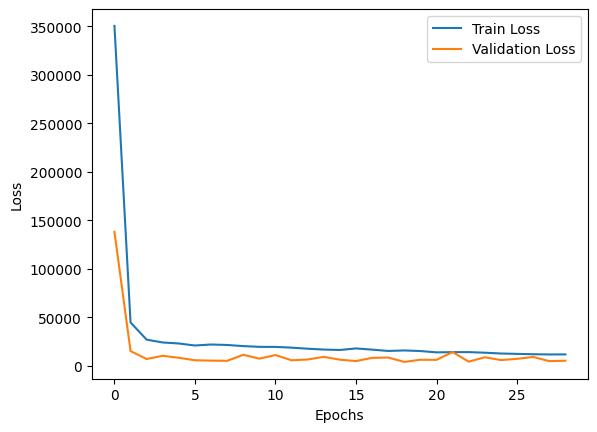

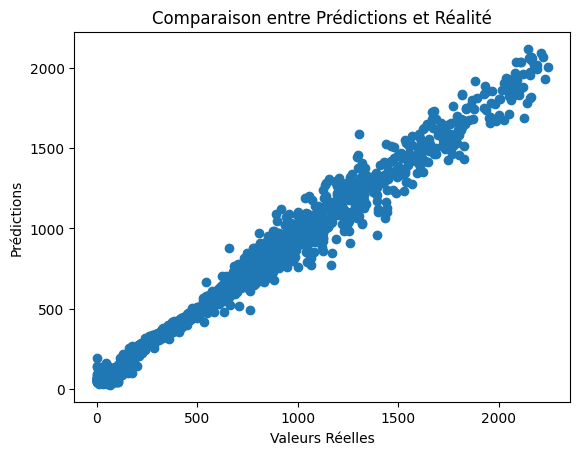

In [10]:
# Courbes de perte
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Comparaison entre valeurs réelles et prédictions
plt.scatter(y_true, y_pred)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison entre Prédictions et Réalité")
plt.show()
